In [145]:
import aerosandbox as asb
import numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from scipy.spatial import Delaunay


In [146]:
def airfoil(nx, ny, name ="NACA0012"):
    af = asb.geometry.Airfoil(name=name)
    coords = af.coordinates

    scale = 25
    xoffset = int(nx/4)
    yoffset = int(ny/2)

    afx = coords[:,0] * scale + xoffset  #shift right xoffset meters
    afy = coords[:,1] * scale + yoffset  #shift up yoffset meters
    pts = np.array([afx, afy]).T
    tri = Delaunay(pts)

    # plt.triplot(tri.points[:,0], tri.points[:,1]) 
    # #^make triangular mesh with x and y. make a complex simplicial complex structure instead of just a triangle
    # plt.plot(pts[:,0], pts[:,1], 'r-')
    # plt.axis('equal')
    # plt.show()
    return tri, afx, afy

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

In [148]:
def grid(h=1):  # h in mm
    nx = int(70 / h) + 1    
    ny = int(20 / h) + 1    
    
    xvals = np.linspace(0, 70, nx)
    yvals = np.linspace(0, 20, ny)
    return nx, ny, xvals, yvals

In [149]:
def init(nx, ny, h):
    u = np.zeros((nx, ny), dtype=float)  # stream function
    w = np.zeros((nx, ny), dtype=float)  # vorticity field 
    v0 = 0.5  
    omega = 0.8  
    nu = 0.5  
    iter = 0
    R = v0*h/nu  
    return u, w, v0, omega, nu, iter, R

In [150]:
def edges(nx, ny, u, w, v0, h = 1):
    
    # init flow
    for i in range(nx):
        for j in range(ny): 
            w[i,j] = 0.0
            u[i,j] = j * v0  

    #top boundary
    for i in range(nx):
        u[i,ny-1] = u[i, ny-2] + v0 * h 
        w[i,ny-2] = 0.0

    #inlet
    for j in range(ny):
        u[1,j] = u[0,j]
        w[0,j] = 0.0

    #bot boundary 
    for i in range(nx):
        u[i, 0] = u[i, 1]  
        w[i, 0] = 0.0
        
    #outlet
    for j in range(1, ny-1):
        u[nx-1,j] = u[nx-2,j]
        w[nx-1,j] = w[nx-2,j]

    return u, w

In [151]:
def BC(u, w, tri, X, Y, nx, ny, h):
    
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            pt = np.array([X[i,j], Y[i,j]])
            simplex = tri.find_simplex(pt)
            if simplex >= 0:
                u[i,j] = 0.0

                # Apply vorticity boundary condition (equation 19.78 in landau)
                # w = -2(u_surface - u_above)/h^2 for top surfaces
                # w = -2(u_surface - u_below)/h^2 for bottom surfaces

                # points outside triangulation are -1
                # for curved surfaces check neighbors to determine surface orientation
                if j < ny-1 and tri.find_simplex(np.array([X[i,j+1], Y[i,j+1]])) < 0:
                    # Point above is outside airfoil -> top surface
                    w[i,j] = -2.0 * u[i,j+1] / (h*h)

                elif j > 0 and tri.find_simplex(np.array([X[i,j-1], Y[i,j-1]])) < 0:
                    # Point below is outside airfoil -> bottom surface 
                    w[i,j] = -2.0 * u[i,j-1] / (h*h)

                elif i < nx-1 and tri.find_simplex(np.array([X[i+1,j], Y[i+1,j]])) < 0:
                    # Point to right is outside -> front surface
                    w[i,j] = -2.0 * u[i+1,j] / (h*h)

                elif i > 0 and tri.find_simplex(np.array([X[i-1,j], Y[i-1,j]])) < 0:
                    # Point to left is outside -> back surface
                    w[i,j] = -2.0 * u[i-1,j] / (h*h)

                else:
                    w[i,j] = 0.0
                    
    return u, w

In [152]:
#@numba.jit(nopython=True)
def relax(nx, ny, u, w, R, omega, h, X, Y, tri):
    u, w = BC(u, w, tri, X, Y, nx, ny, h)

    for i in range(1,nx-1): 
        for j in range(1,ny-1):
            pt = np.array([X[i,j], Y[i,j]])
            if tri.find_simplex(pt) < 0: # only points outside airfoil
                r1 = omega * ((u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] + h*h*w[i,j])*0.25 - u[i,j])
                u[i,j] += r1

    for i in range(1, nx-1):
        for j in range(1, ny-1):
            pt = np.array([X[i,j], Y[i,j]])
            if tri.find_simplex(pt) < 0: # only points outside airfoil
                a1 = w[i+1,j] + w[i-1,j] + w[i,j+1] + w[i, j-1]
                a2 = (u[i, j+1] - u[i, j-1]) * (w[i+1,j] - w[i-1,j])
                a3 = (u[i+1, j] - u[i-1,j]) * (w[i,j+1] - w[i,j-1])
                r2 = omega * ((a1 - (R/4.0)*(a2 - a3))/4.0 - w[i,j])
                w[i,j] += r2
                # Clip to prevent explosion
                w[i,j] = np.clip(w[i,j], -100, 100)

    return u, w            

In [153]:
h = 1  # grid spacing

print("init")
nx, ny, xvals, yvals = grid(h)
tri, afx, afy = airfoil(nx, ny, name ="NACA4415") # NACA0012 basic / NACA2412 good too
X, Y = np.meshgrid(xvals, yvals, indexing='ij') 
u, w, v0, omega, nu, iter, R = init (nx, ny, h)
print("BC")
u, w = edges (nx, ny, u, w, v0, h) # apply edge BCs first
u, w = BC(u, w, tri, X, Y, nx, ny, h) # apply object BCs


print("relax")
maxiter = 500  # increased for better convergence
tol = 1e-6
for iter in range(maxiter):
    u_old = u.copy()
    u, w = relax(nx, ny, u, w, R, omega, h, X, Y, tri)

    delta = np.max(np.abs(u - u_old))
    if iter % 10 == 0:
        print(f"Iteration: {iter}")

    if delta < tol:
        print(f"Converged after {iter} iterations.")
        break

print("plot")
# Create proper meshgrid for plotting
x = np.linspace(0, 70, nx)  # Use array indices for plotting
y = np.linspace(0, 20, ny)
xplot, yplot = np.meshgrid(x, y, indexing='ij')


init
BC
relax
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200
Iteration: 210
Iteration: 220
Iteration: 230
Iteration: 240
Iteration: 250
Iteration: 260
Iteration: 270
Iteration: 280
Iteration: 290
Iteration: 300
Iteration: 310
Iteration: 320
Iteration: 330
Iteration: 340
Iteration: 350
Iteration: 360
Iteration: 370
Iteration: 380
Iteration: 390
Iteration: 400
Iteration: 410
Iteration: 420
Iteration: 430
Iteration: 440
Iteration: 450
Iteration: 460
Iteration: 470
Iteration: 480
Iteration: 490
plot


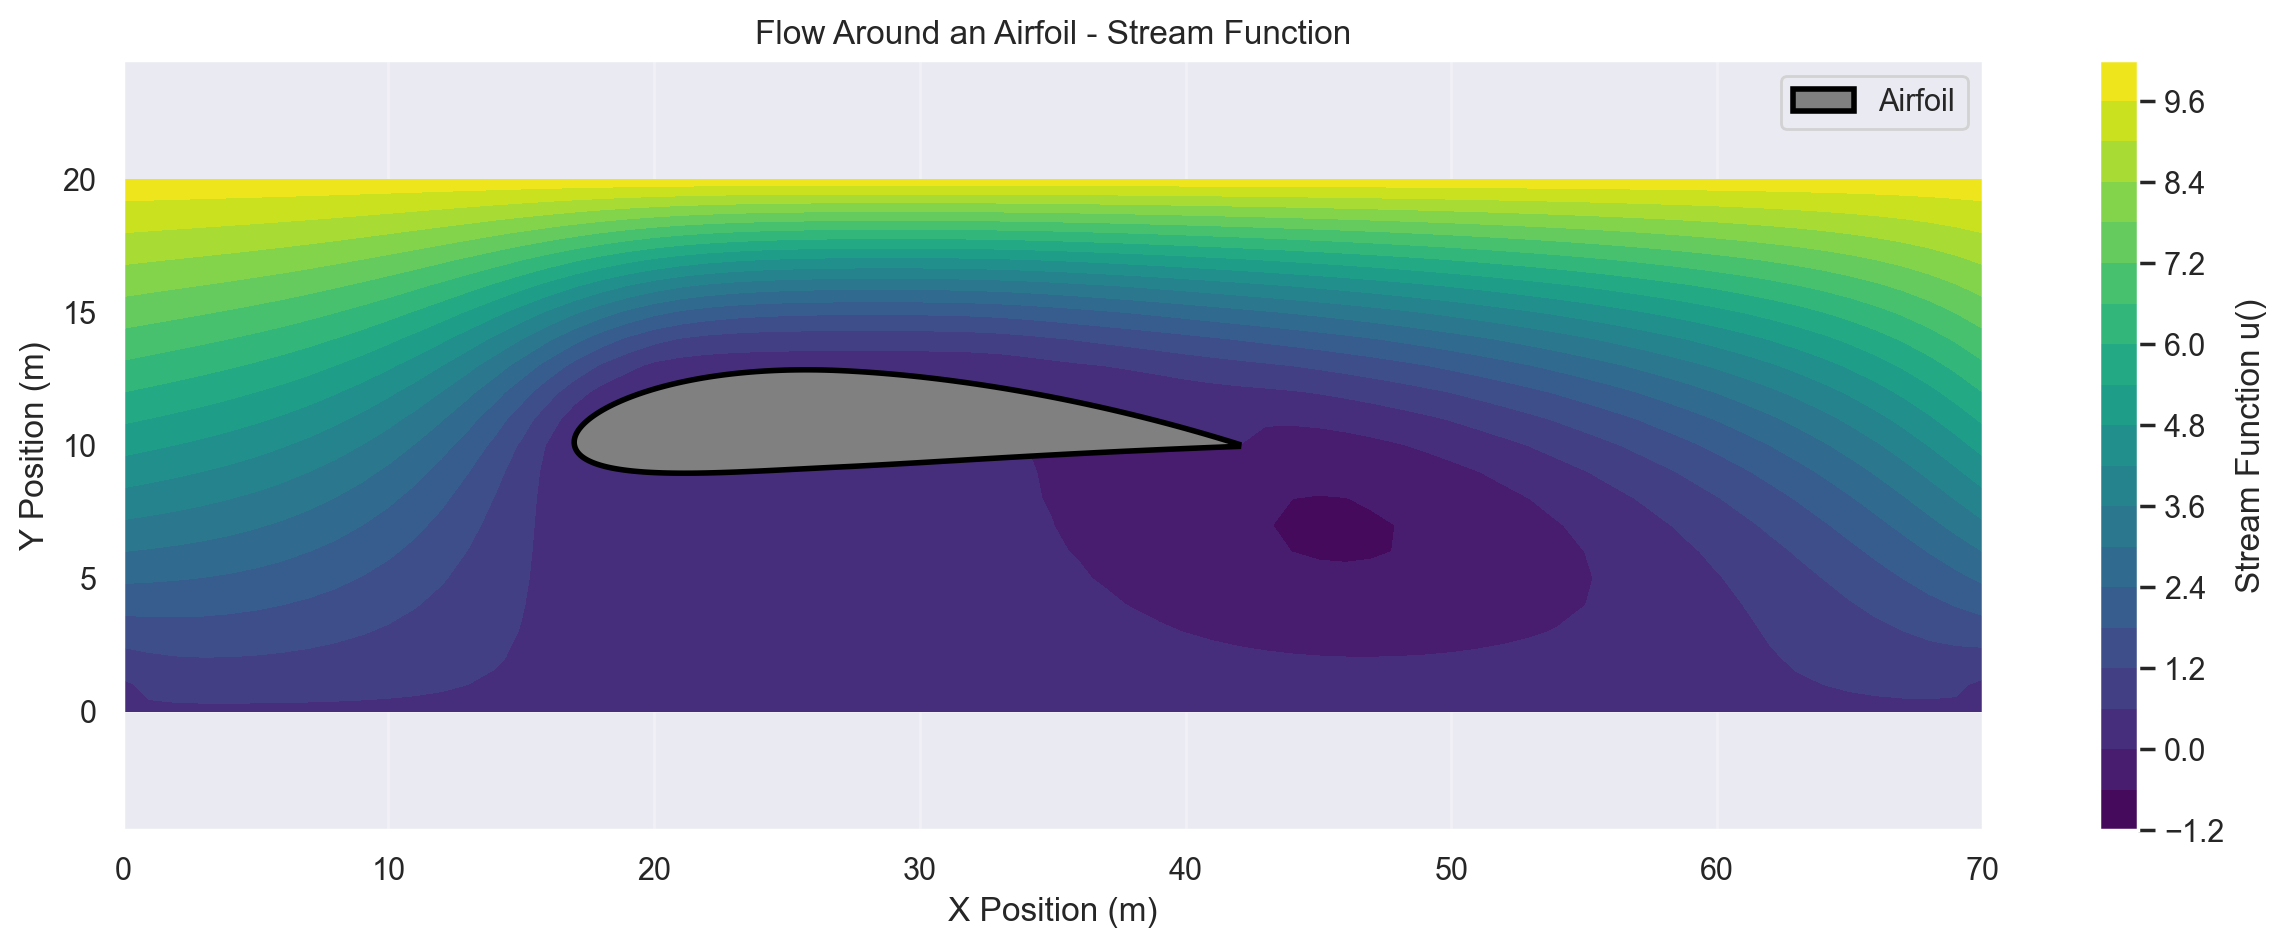

In [154]:
plt.figure(figsize=(15, 5))
# Use more levels and smoother interpolation for better visual quality
contour = plt.contourf(xplot, yplot, u, levels=20, cmap='viridis')
plt.colorbar(contour, label='Stream Function u()')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D Stream Function Contours - Flow Around Airfoil')
plt.axis('equal')

# Add airfoil
plt.fill(afx, afy, color='gray', label='Airfoil', edgecolor='black', linewidth=2)
# Add streamlines for smoother visualization
#plt.contour(xplot, yplot, u, levels=15, colors='white', alpha=0.3, linewidths=0.5)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Flow Around an Airfoil - Stream Function')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

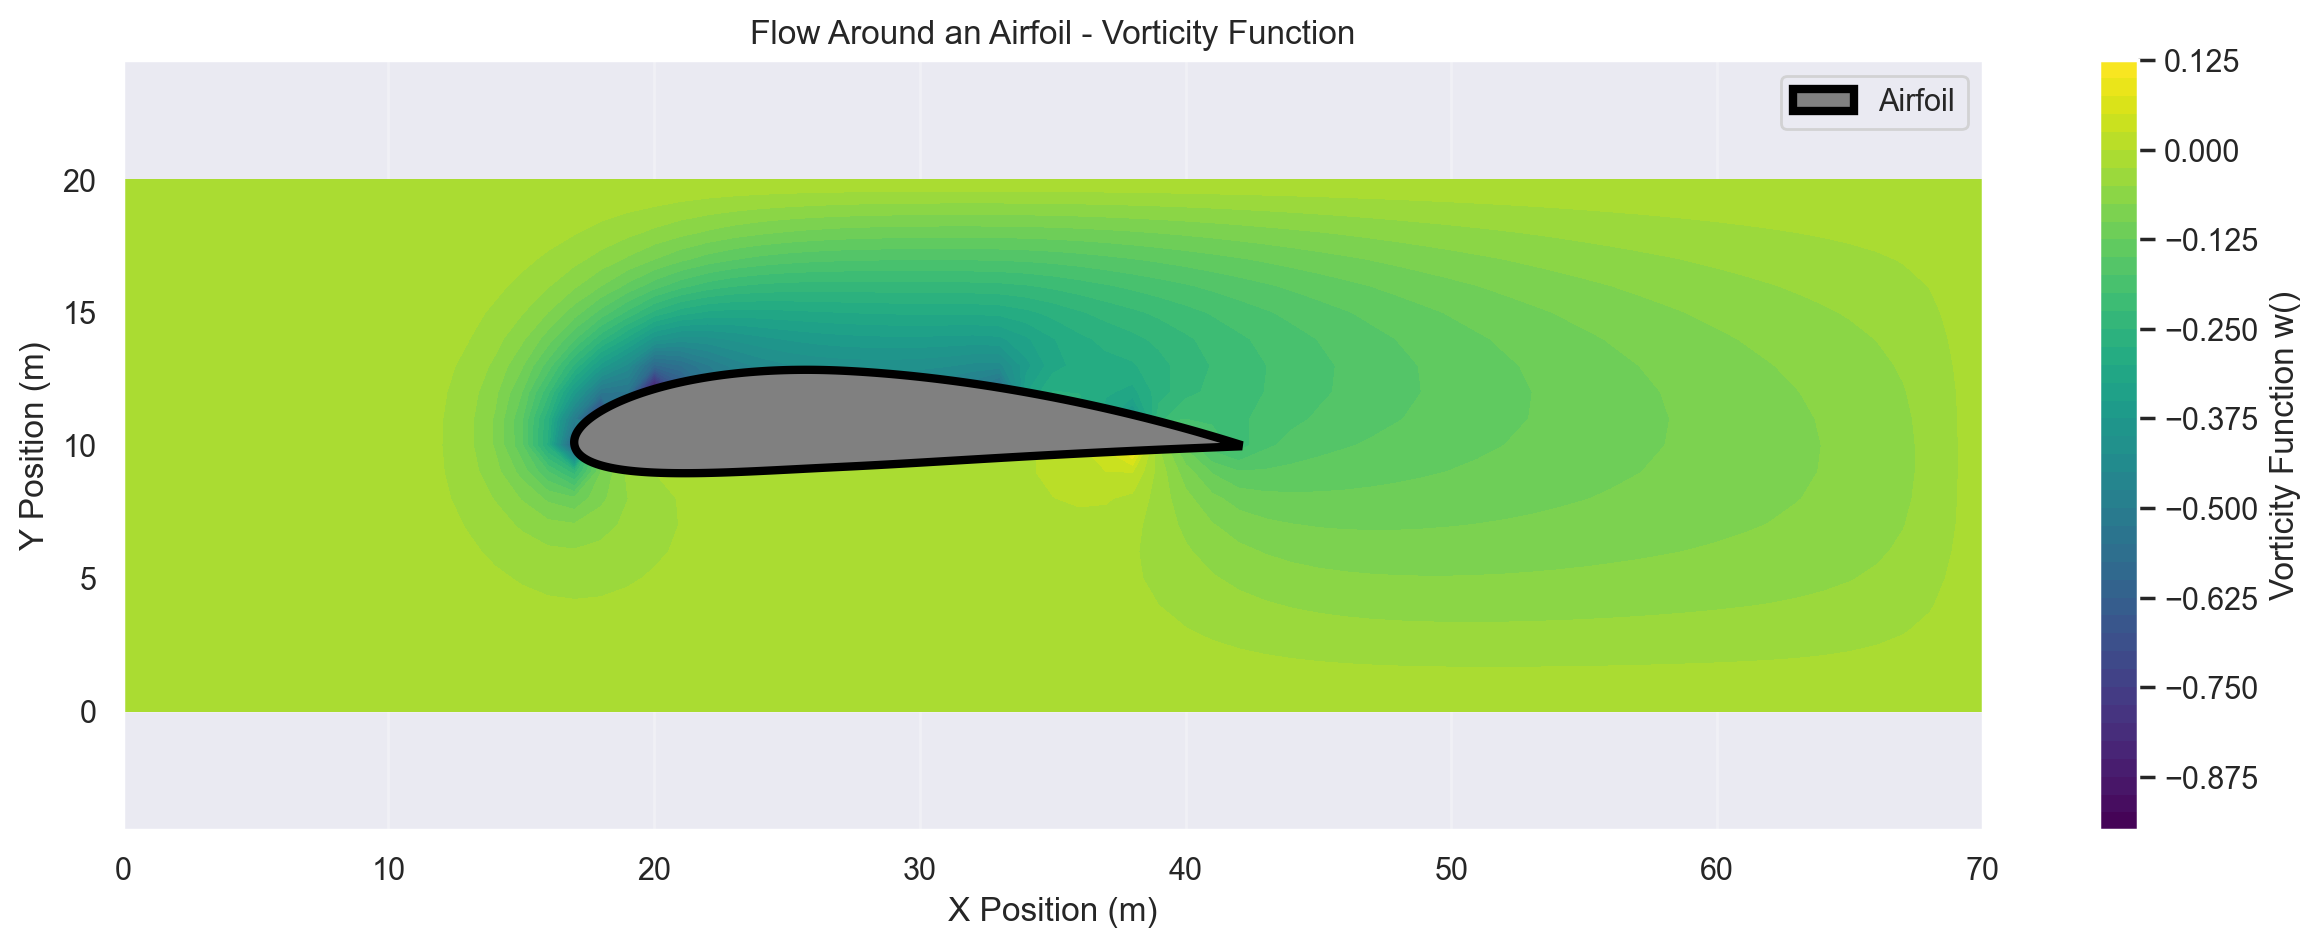

In [155]:
plt.figure(figsize=(15, 5))
contour = plt.contourf(xplot, yplot, w, levels=50, cmap='viridis')
plt.colorbar(contour, label='Vorticity Function w()')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D Vorticity Contours - Flow Around Airfoil')
plt.axis('equal')

# Add airfoil
plt.fill(afx, afy, color = 'gray',label='Airfoil', edgecolor='black', linewidth=3)
#plt.clabel(plt.contour(xplot, yplot, w, levels=20, colors='k', alpha=0.5), inline=True)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Flow Around an Airfoil - Vorticity Function')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

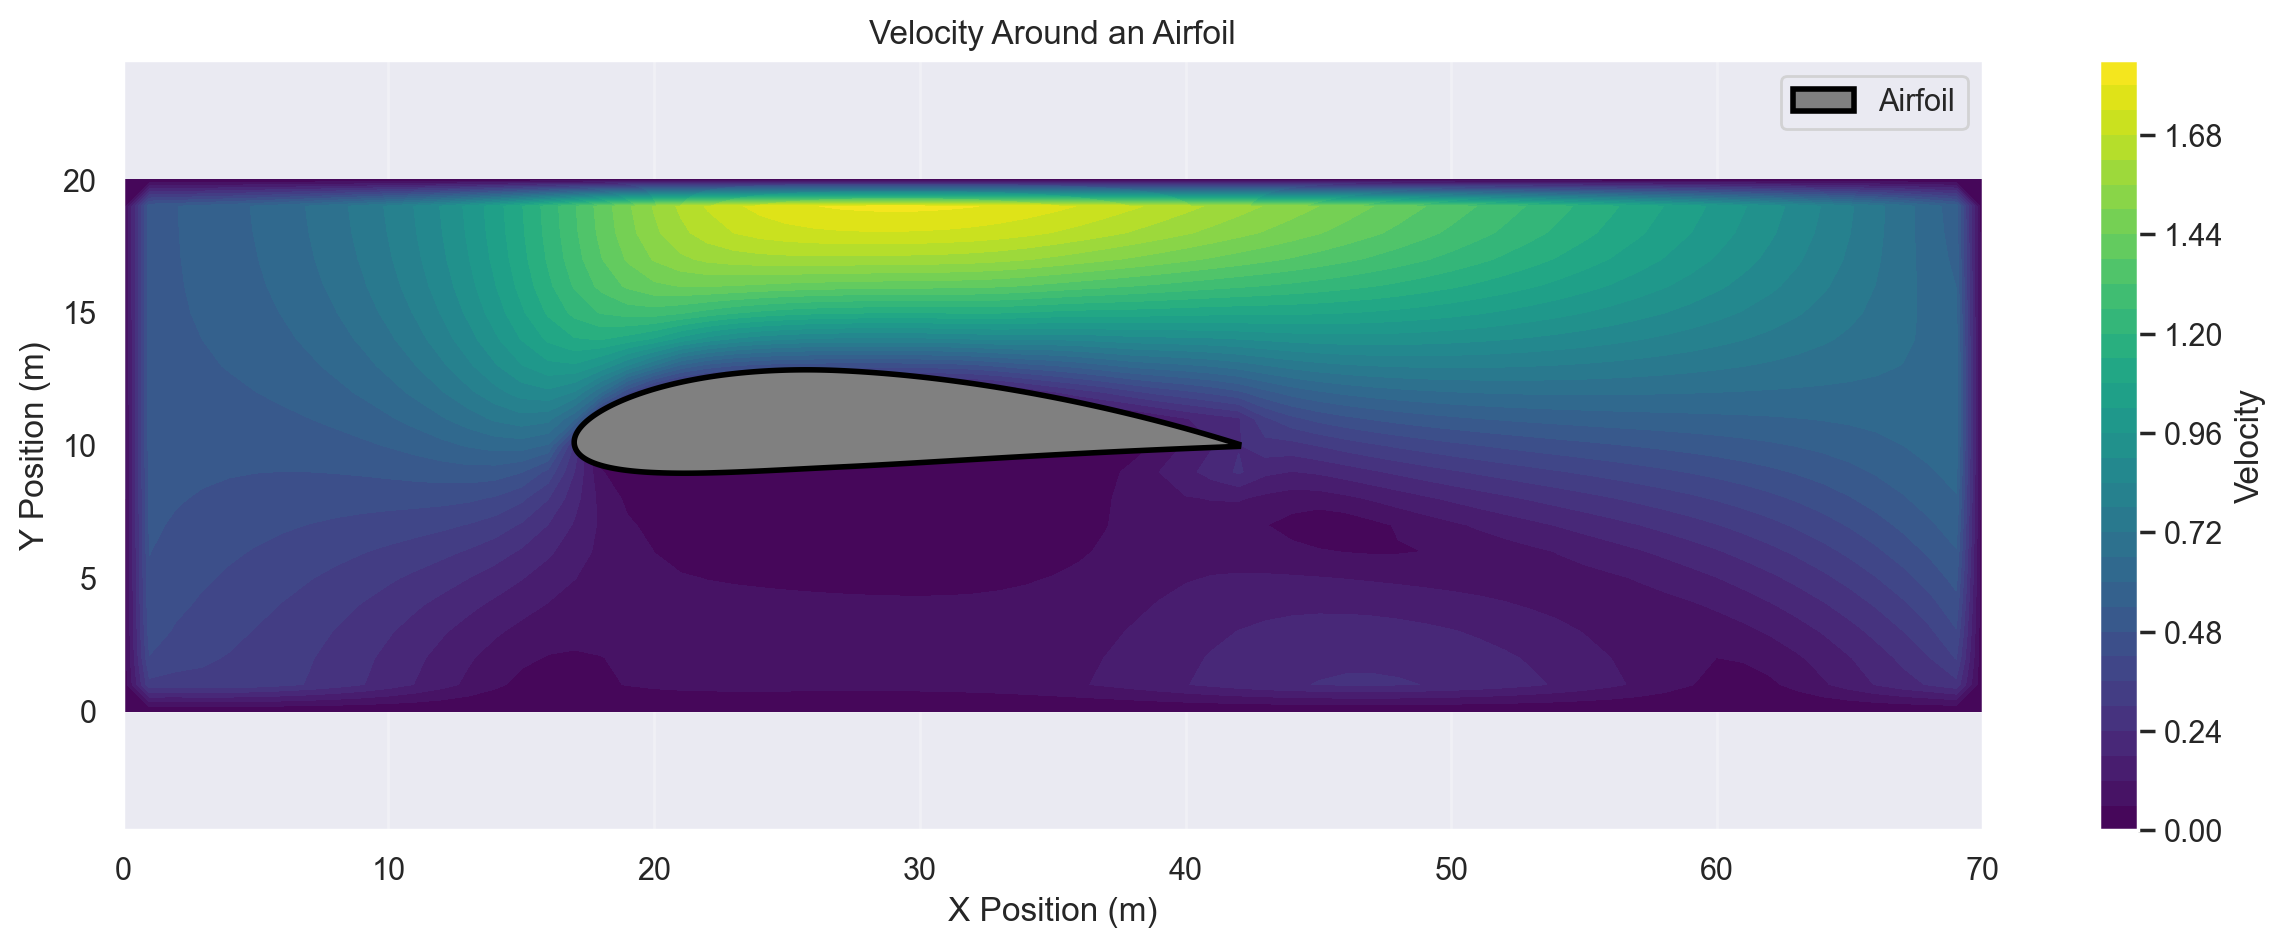

In [156]:
def calcVelo(u, h):
    nx, ny = u.shape
    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny))
    
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            vx[i,j] = (u[i,j+1] - u[i,j-1]) / (2 * h)   # eq 19.54 // central difference
            vy[i,j] = -(u[i+1,j] - u[i-1,j]) / (2 * h)  
            
    return vx, vy

vx, vy = calcVelo(u, h)
veloMag = np.sqrt(vx**2 + vy**2)

plt.figure(figsize=(15, 5))
contour = plt.contourf(xplot, yplot, veloMag, levels = 30, cmap='viridis')
plt.colorbar(contour, label='Velocity')
plt.fill(afx, afy, color='gray', label='Airfoil', edgecolor='black', linewidth=2)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Velocity Around an Airfoil')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()
